<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Lab 1: Intro to TensorFlow and Music Generation with RNNs

# Part 2: Music Generation with RNNs

In this portion of the lab, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music. 

해당 실습에서는, 음악 생성(music generation)을 위한 RNN 구축을 알아보겠습니다. 모델이 ABC notation으로 표현된 악보에서 패턴을 학습하도록 훈련한 후 이 모델을 이용하여 새로운 음악을 생성할 것입니다.

- ABC noation이란 악보를 A부터 G까지 문자 표기법을 사용하여 나타낸 것을 말합니다. 번호, 제목, 작곡가, 음표, 길이, 음계 등이 포함되어 있고 각 알파벳 별로 의미하는 것이 정해져 있습니다. 

## 2.1 Dependencies 
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

먼저 course 저장소를 다운로드하고, 필요한 것들을 설치한 후, 실습에서 필요한 관련 패키지들을 불러옵니다.

In [2]:
# Import Tensorflow 2.0
# %tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
#assert len(tf.config.list_physical_devices('GPU')) > 0

지정된 경로를 찾을 수 없습니다.


## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it: 


ABC notation으로 표현된 수천 개의 아일랜드 민요(Irish folk songs) 데이터를 수집해놨습니다. 이 데이터셋을 다운로드하고 불러와보겠습니다(inspect).

In [12]:
# Download the dataset
# colab으로 실행한다면 주석과 같이 작성할 것 
# jupyter notebook으로 실행한다면 아래와 같이 작성할 것 
# import pattern과 관련해서 수정해주어야 오류가 해결되는 것 같습니다
from mitdeeplearning import lab1
#songs = mdl.lab1.load_training_data()
songs = lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
# 하나의 노래를 출력해서 세부사항을 확인해봅시다
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


We can easily convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

ABC notation 표기법의 노래를 오디오 파형(audio file)으로 쉽게 변환하여 재생할 수 있습니다. 이 변환에는 시간이 걸릴 수 있기 때문에 조금 기다리길 바랍니다. 

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

한 가지 중요한 점은 이 음악 표기법은 단순히 연주되는 음에 대한 정보만 담고 있는 것이 아니라 추가적으로 노래 제목, 키, 템포와 같은 메타 정보를 포함하고 있다는 것입니다. 텍스트 파일에 존재하는 다양한 문자들이 학습 문제의 복잡성(complexity of the learning problem)에 어떤 영향을 미칠까요? 이는 곧, 텍스트 데이터에서 수치적인(numeric) 표현을 만들어낼 때 중요해질 것입니다. 

In [13]:
# Join our list of song strings into a single string containing all songs
# 노래 문자열(string) 목록을 이 모든 노래가 포함된 하나의 단일 문자열로 결합함
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
# 결합된 노래 묶음 문자열에서 유일한(unique) 단어들을 모두 확인
# 데이터셋에는 총 83개의 유일한 문자들이 존재함
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

한발 물러서서 우리의 예측 수행 과제(prediction task)에 대해 생각해 봅시다. 우리는 RNN 모델이 ABC 표기 음악에서 패턴을 학습하도록 훈련할 것이며, 그 후 이 모델을 학습한 정보를 바탕으로 새로운 음악 생성(또는 예측)에 사용할 것입니다.

이를 분해해서 생각하면, 우리가 모델에게 정말로 요구하는 것은 주어진 문자, 문자들의 시퀀스, 다음 문자로 올 가장 가능성 높은 문자는 무엇인가? 가 됩니다. 우리는 모델이 이 작업들을 수행할 수 있도록 훈련할 것입니다. 

이를 달성하기 위해서, 모델에게 문자열 시퀀스를 넣을 것이고, 모델이 출력을 예측할 것인데, 이때 말하는 출력은 각 time step에서 다음 문자를 예측하는 것을 말합니다. RNN은 이전에 본 요소에 의존하는 내부 state를 유지하므로, 주어진 순간까지 보여준 모든 문자 정보들은 다음 예측을 생성할 때 고려 대상이 됩니다. 

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

RNN 모델을 훈련하기 전에, 텍스트 기반의 데이터셋을 수치적으로 표현(numerical representation, 숫자 표현)할 필요가 있습니다. 이를 위해서, 두 개의 조회 테이블(lookup tables)를 생성하겠습니다. 하나는 문자를 숫자에 매핑하고, 나머지 하나는 숫자를 다시 문자로 매핑합니다. 우리가 앞서 텍스트에 있는 유일한(unique) 문자들을 확인했던 것을 기억하세요. 

In [15]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
# 문자 -> unique index로 매핑
# 예를 들어, "d"라는 문자의 인덱스는 char2idx["d"]와 같이 작성하여 얻을 것임 
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
# index -> 문자로 매핑 
# char2idx의 반대 버전이며 index에서 다시 문자로 되돌리는 역할을 할 것임
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

이는 각 문자에 대한 정수 표현을 제공해줄 것입니다. 텍스트 속 유일 문자(즉, 우리가 만든 어휘, 단어장, vocabulary)는 0에서 `len(unique)`까지의 인덱스로 매핑되는지 관찰해봅시다. 데이터셋의 정수 표현(numerical representation)을 살펴봅시다. 

- [python] difference between str() and repr() 
- 숫자를 문자열로 변환시켜주는 함수입니다 

In [16]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [17]:
'''
모든 노래 문자열을 벡터화(즉, 정수로)해주는 함수를 작성하시오
위에서 본 적절한 매핑을 사용하여 vocab 문자를 각각에 해당하는 인덱스로 변환하세요 

참고 : 'vectorize_string' 함수의 결과는 무조건 'N' 요소의 np.array 이여야 합니다. 
그리고 여기서 'N'은 입력 문자열의 문자의 개수입니다. 
'''

"\n모든 노래 문자열을 벡터화(즉, 정수로)해주는 함수를 작성하시오\n위에서 본 적절한 매핑을 사용하여 vocab 문자를 각각에 해당하는 인덱스로 변환하세요 \n\n참고 : 'vectorize_string' 함수의 결과는 무조건 'N' 요소의 np.array 이여야 합니다. \n그리고 여기서 'N'은 입력 문자열의 문자의 개수입니다. \n"

In [8]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function 
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
    # TODO
    vectorized_list = []
    vectorized_list = ([char2idx[_] for _ in string])
    return np.array(vectorized_list)

vectorized_songs = vectorize_string(songs_joined)
vectorized_songs

array([49, 22, 13, ..., 22, 82,  2])

We can also look at how the first part of the text is mapped to an integer representation:

우리는 이제 텍스트 속 첫 번째 파트가 어떻게 숫자로 표현되는지 볼 수 있습니다.

In [18]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

다음 단계는 실제로 텍스트를 훈련 중에 사용할 예제 시퀀스로 나누는 것입니다. RNN에 집어넣을 각각의 입력 시퀀스는 텍스트의 `seq_length` 문자를 포함합니다. 또한 각 입력 시퀀스에 대한 타겟(target) 시퀀스를 정의해야 하는데, 이는 RNN이 다음 문자를 예측하기 위한 훈련에 사용됩니다. 각 입력 시퀀스에 대해, 오른쪽으로 문자 하나를 이동시킨 것을 제외하고, 입력에 대응하는 타겟 시퀀스는 동일한 길이의 텍스트를 포함합니다. 

이를 위해 텍스트를 `seq_length+1`의 덩어리(청크) 단위로 나누겠습니다. `seq_length`가 4 이고 텍스트가 "Hello"라고 가정해봅시다. 그렇다면 입력 시퀀스는 "Hell"이 되고 타겟 시퀀스는 "ello"가 됩니다. 

그런 다음 batch 방법을 사용하여 해당 문자 인덱스 스트림을 원하는 크기의 시퀀스로 변환할 수 있습니다. 

In [20]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

이 각각의 벡터에 대해, 각 인덱스는 하나의 단일 time step으로 처리됩니다. 그러므로, time step 0의 입력의 경우, 모델은 시퀀스의 첫 번째  문자에 대한 인덱스를 받고, 다음 문자의 인덱스를 예측하려고 할 것입니다. 그 다음 time step에서도 동일하게 반복하지만, RNN은 이전 step에서의 정보, 즉 현재 입력 외에 업데이트 된 state를 고려합니다. 

우리는 텍스트의 첫 몇개의 문자들로 이것이 어떻게 동작하는지 살펴보고 구체화해 볼 수 있습니다. 

In [21]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 1 (' ')
  expected output: 43 ('R')
Step   1
  input: 43 ('R')
  expected output: 70 ('o')
Step   2
  input: 70 ('o')
  expected output: 56 ('a')
Step   3
  input: 56 ('a')
  expected output: 59 ('d')
Step   4
  input: 59 ('d')
  expected output: 1 (' ')


## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

이제 우리는 ABC 음악 데이터셋에 맞춰 RNN 모델을 훈련하고 훈련한 모델로 새로운 음악을 만들 준비를 마쳤습니다. 이전 섹션에서 생성한 데이터셋의 음악 조각을 사용하여 RNN을 훈련할 것입니다. 

모델은 LSTM 구조를 기반하는데, 이 구조는 연속되는 문자들 사이의 시간 관계(temporal relationships)에 대한 정보를 유지하는 state 벡터를 사용합니다. LSTM의 최종 출력은 fully-connected `Dense` layer로 넘겨지는데, 여기서 vocabulary의 각 문자에 대해 softmax를 계산하고(출력하고) 이로부터 만들어진 불포에서 샘플을 추춘하여 다음 문자를 예측합니다. 

이번 실습의 첫 부분에서도 소개했듯이, 우리는 모델을 정의하기 위해 keras API [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential)를 사용합니다. 모델을 정의하기 위해 세 개의 레이어가 사용됩니다. 

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) : 입력 레이어, 각 문자의 숫자들을 `embedding_dim`차원의 벡터로 매핑하는 훈련 가능한 lookup 테이블로 구성됨 
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): `units=rnn_units` 크기의 LSTM 신경망
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): `vocab_size` 출력이 있는 출력 레이어

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

이제 모델을 실제로 만들기 위해 사용할 함수를 정의하겠습니다. 

In [22]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

때가 됐습니다! `TODOs`를 채워 `build_model`함수 내에서 RNN 모델을 정의한 다음, 정의한 함수를 호출하여 모델을 인스턴스화합시다!

In [27]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

우리의 모델이 예상대로 잘 작동하는지 확인하기 위해 몇 가지 간단한 검사를 해보는 것은 항상 좋은 생각입니다. 

우선, `Model.summary` 함수를 사용하여 모델의 내부 작동에 대한 summary를 출력할 수 있습니다. 이로부터 모델 내부의 레이어, 각 레이어의 출력 형태(shape), 배치 사이즈 등을 확인해 볼 수 있습니다. 

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (32, None, 256)           21248     
                                                                 
 lstm_1 (LSTM)               (32, None, 1024)          5246976   
                                                                 
 dense_1 (Dense)             (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

우리는 또한 길이 100의 시퀀스를 사용하여 출력물의 차원도 빠르게 확인해 볼 수 있습니다. 모델은 어떤 길이의 입력에서도 작동할 수 있음을 알아두세요.

In [29]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

자, 우리의 훈련시키지 않은 모델이 무엇을 예측할지 확인해봅시다. 

모델의 실제 예측을 얻기 위해서, 우리는 문자 vocabulary를 `softmax`로 정의한 출력 분포에서 샘플을 추출해야 합니다. 이는 우리에게 실제 문자 인덱스틀 제공합니다. 즉, 범주형 분포([categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) )을 사용하여 예제 예측을 샘플로 추출함을 의미합니다. 이로써 각 time step에서 다음 문자(특히나 그 인덱스에서의)에 대한 예측을 하게 됩니다. 

여기서는 단순히 `argmax`를 취하는 대신 확률 분포에서 표본을 추출합니다. (그리고 argmax는 모델이 루프에 빠지게 만들 수 있습니다?)

첫 번째 예시 batch에서 샘플링을 실행해봅시다. 

In [30]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([21, 17, 61, 29, 17, 46, 15, 55, 24, 42, 71, 81, 77, 38, 37, 65, 24,
       30, 48, 39, 77, 54, 28, 75, 66, 24, 82, 27, 19,  1, 13, 16, 27, 23,
       12, 38, 62,  4, 36, 79, 41, 26, 20, 17, 26, 64, 76, 24, 23, 37,  5,
       24, 67, 79, 57, 80, 66, 43, 66, 31, 46,  4, 17, 59, 59,  5, 71, 36,
       56, 38, 18, 66, 71, 65, 72, 57, 19, 48, 39,  0, 35, 59, 40,  0, 67,
       40, 54,  7, 61, 25, 57, 71, 34, 28, 44, 81, 10, 65, 36, 15],
      dtype=int64)

We can now decode these to see the text predicted by the untrained model:

이제 이들을 디코딩하여 훈련되지 않은 모델이 예측한 텍스트를 확인할 수 있습니다. 

In [31]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 ':dc-setdance-28\nM:6/8\nL:1/8\nK:D Major\nded fed|cBA cec|BcB fdB|BcB fdB|!\nded fed|cBA cec|ABA ecA|ABA '

Next Char Predictions: 
 "95fD5U3_=QpzvMLj=EWNv^Ctk=|B7 14B<0Mg#KxPA85Aiu=<L'=lxbykRkFU#5dd'pKaM6kpjqb7WN\nJdO\nlO^)f>bpICSz.jK3"


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

여러분들도 볼 수 있듯이, 훈련되지 않은 모델의 예측 텍스트는 굉장히 터무니없네요! 어떻게 해야 할까요? 신경망을 훈련시켜봅시다!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model: 

자 이제 모델을 훈련시킬 시간입니다!

이때, 우리는 다음 문자를 예측하는 문제를 일반적인 분류 문제(classification)로 생각해 볼 수 있습니다. RNN의 이전 state와 주어진 time step에서의 입력을 고려할 때, 우리는 다음 문자에 대한 class를 예측하고 싶어합니다. 즉, 다음 문자를 실제로 예측하는 것이 되는 것이죠. 

이 분류 작업에 대해 모델을 훈련시키기 위해, 우리는 `crossentropy` loss 형태를 사용할 수 있습니다. 특히나, 우리는 [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy) loss를 사용할 것인데, 해당 loss는 범주형 분류 작업을 위해 정수 타겟을 사용하기 때문입니다. 우리는 실제 타겟(`labels`)과 예측 타겟(`logits`)을 사용하여 loss를 계산하길 원합니다. 

먼저 훈련시키지 않은 모델의 예시 예측을 사용해 loss를 계산해봅시다. 

In [38]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4177337


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!

모델 훈련을 위해 하이퍼파라미터들을 정의해봅시다. 시작하기 앞서 우선, 일부 파라미터에 대해 합리적인 값들을 제공했습니다. 수업 시간에 배운 내용을 사용하여 여기서 파라미터 선택을 최적화하는 것은 여러분에게 달려있습니다! (최적의 파라미터 찾기) 

In [40]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

이제, 우리의 훈련 작업(최적화와 훈련 기간)을 정의하고 이 함수를 사용하여 모델을 훈련할 준비가 되었습니다. 여러분들은 optimizer와 모델을 훈련할 기간을 선택함으로써 실험해볼 수 있고, 이러한 변화들이 신경망의 출력에 어떤 영향을 주는지를 볼 수 있습니다. 여러분들이 시도해볼 만한 몇몇 optimizer로는 [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) 과 [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable). 가 있습니다. 

먼저, 우리는 새로운 모델과 optimizer를 예시로 들 것 입니다. 그 후, 역전파 작업을 수행하기 위해 [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape)를 사용합니다. 

또한 우리는 훈련 동안 모델의 진행 상황을 출력하여 loss를 최소화하고 있는지에 대한 여부를 쉽게 시각화 해보도록 하겠습니다. 

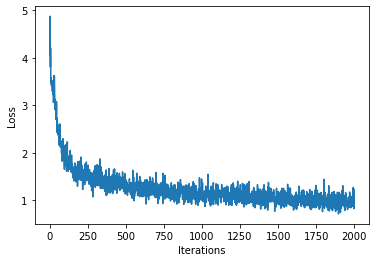

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [6:19:14<00:00, 11.38s/it]


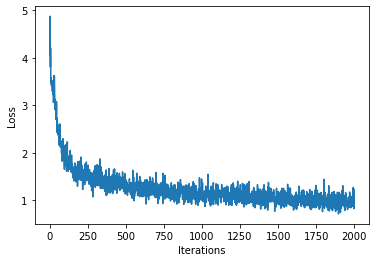

In [42]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

이제, 음악을 만들기 위해 우리의 훈련된 RNN 모델을 사용할 수 있습니다! 음악을 만들어낼 때, 우리는 모델의 시작을 위해 몇 가지 시드를 공급해야 합니다. (왜냐하면 아무것도 없이 시작해서는 무엇도 예측할 수 없으니까요!) 

일단 우리가 생성된 시드를 가지고 나면, 우리는 훈련된 RNN을 사용하여 각각의 연속적인 문자를 반복적으로 예측할 수 있습니다(ABC 표기법의 음악을 사용한다는 걸 기억하세요). 보다 구체적으로 말하자면, 우리의 RNN은 가능한 연속적인 문자로 `softmax`를 출력한다는 것을 기억하세요. 추론(Inference)을 하는 동안, 이런 분포로부터 반복적으로 표본을 추출한 다음 생성된 노래를 ABC 표기법으로 인코딩하는 데 샘플을 사용합니다. 

자, 여러분들이 할 일은 파일로 작성하고 노래를 듣는 것만 남았습니다!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

추론(Inference) 단계를 간단하게 하기 위해서, batch 크기는 1로 사용할 겁니다. RNN의 state가 timestep에서 timestep으로 전달되는 방식 때문에, 모델은 오로지 한번 설정된 고정 batch 크기만을 수용할 수 있습니다. 

In [43]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_4 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_4 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Notice that we have fed in a fixed `batch_size` of 1 for inference.

추론(Inference)를 위해 고정 batch 크기 1을 입력하였습니다. 

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

이제 ABC 음악 형식으로 텍스트를 생성하기 위해 코드를 작성할 준비가 되었습니다. 
- "시드" 시작 문자열과 RNN state를 초기화 하고, 생성할 문자 수를 설정합니다.
- 시작 문자열과 RNN state를 사용하여 다음 예측 문자에 대한 확률 분포를 얻습니다. 
- 예측 문자의 인덱스를 계산하기 위해 다항 분포 표본으로부터 샘플링합니다. 그런 다음 이 예측 문자를 모델의 다음 입력으로 사용합니다. 
- 각 time step에서, 업데이트 된 RNN state는 다시 모델에 공급되어, 다음 예측을 만들 때 더 많은 컨텍스트(context)를 갖게 됩니다. 다음 문자를 예측한 후, 업데이트 된 RNN states는 다시 모델에 공급되고, 이는 이전 예측으로부터 더 많은 정보를 얻기 때문에 데이터 속에서 시퀀스 종속성을 학습하게 하는 방법이 됩니다. 

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

코드 블록(신경망 정의 및 훈련의 일부분도 포함!)을 완성하고 실험하여 모델이 어떻게 동작하는지 확인해 봅시다. 짧은 epoch으로 훈련하여 만들어진 노래와 더 긴 epoch으로 훈련하여 만들어진 노래를 비교해 볼 때 어떻게 될 것 같나요?

In [49]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  #input_eval = [vectorize_string(start_string)]
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [50]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.26it/s]


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

이제 우리는 ABC 형태의 텍스트를 오디오 파일로 변환하는 함수를 호출하여 생성한 음악을 확인하기 위해 실행할 수 있습니다! 만약 결과로 나온 노래가 충분히 길지 않다면 더 오래 훈련하거나 노래를 다시 만들어보세요! 

In [52]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 5 songs in text


## 2.7 Experiment and **get awarded for the best songs**!

Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

Consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset? 
*  Does the choice of start string significantly affect the result? 

Try to optimize your model and submit your best song! **MIT students and affiliates will be eligible for prizes during the IAP offering**. To enter the competition, please [email us](mailto:introtodeeplearning-staff@mit.edu) with your name and the following:

* a recording of your song;
* Jupyter notebook with the code you used to generate the song;
* a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description.

You can also tweet us at [@MITDeepLearning](https://twitter.com/MITDeepLearning) a copy of the song! See this example song generated by a previous 6.S191 student (credit Ana Heart): <a href="https://twitter.com/AnaWhatever16/status/1263092914680410112?s=20">song from May 20, 2020.</a>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Have fun and happy listening!

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)